In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pytz
import torch

In [2]:
# load grid data
csv_names = ["0_1000", "1000_3000", "3000_5000", "5000_7000", "7000_8000", "8000_10000"]
grid_data_all = []
for names in csv_names:
    data = pd.read_csv(f"../data/Pecan Street Smart Meter Data (large) (raw)/{names}.csv")
    num_columns = len(data.columns)
    half_index =int((num_columns+1)/2)
    grid_data = data.iloc[:, :half_index]

    ids = ["Datetime"]
    for i in range(len(grid_data.columns)-1):
        match = re.search(r'\((\d+)\)', grid_data.columns[i+1])
        id = match.group(1)
        id = int(id)
        ids.append(id)
    grid_data.columns = ids
    grid_data_all.append(grid_data.iloc[:, 1:])
grid_data_all = pd.concat([grid_data_all[0], grid_data_all[1], grid_data_all[2], grid_data_all[3], grid_data_all[4], grid_data_all[5]], axis=1)
grid_data_all = grid_data_all.fillna(0)

# filter
profile = pd.read_csv('../data/Pecan Street Smart Meter Data (large) (raw)/metadata.csv')
profile = profile[profile['city'] == 'Austin']
profile = profile[profile['solar'] == 'yes']
profile = profile[profile['pv'] == 'yes']
profile = profile[profile['car1'] != 'yes']
profile = profile.sort_values(by='dataid', ascending=True)
ids = profile["dataid"].tolist()
grid_data_all = grid_data_all[grid_data_all.columns[grid_data_all.columns.isin(ids)]]
ids_filter = [171, 483, 499, 668, 890, 1192, 2129, 2199, 2233, 2461, 
              2945, 2986, 3456, 3506, 5218, 5275, 5784, 5796, 5921, 6063, 
              6578, 7429, 7536, 7731, 7741, 8084, 8243, 8995, 9001, 9121]
grid_data_all = grid_data_all[grid_data_all.columns[grid_data_all.columns.isin(ids_filter)]]
columns_to_keep = grid_data_all.columns[~(grid_data_all.iloc[:96] == 0).all()]
grid_data_all = grid_data_all[columns_to_keep]

In [3]:
grid_data_all.shape

(34940, 30)

In [4]:
datetime = pd.DataFrame(grid_data["Datetime"])
datetime["date"] = pd.to_datetime(datetime['Datetime']).dt.date
datetime['time'] = pd.to_datetime(datetime['Datetime']).dt.time
unique_dates = datetime['date'].unique()
unique_times = datetime['time'].unique()
unique_dates.sort()
unique_times.sort()
unique_dataid = grid_data_all.columns
num_dates = len(unique_dates)
num_intervals = len(unique_times)
num_dataid = len(grid_data_all.columns)
mean_by_dataid = list(grid_data_all.mean())
mean_by_dataid = torch.tensor(mean_by_dataid).view(-1, 1, 1)
tensor_grid = mean_by_dataid.repeat(1, num_dates, num_intervals)

In [5]:
date_to_index = {date: idx for idx, date in enumerate(unique_dates)}
time_to_index = {time: idx for idx, time in enumerate(unique_times)}
dataid_to_index = {dataid: idx for idx, dataid in enumerate(unique_dataid)}

In [6]:
grid_data_all

,171,483,499,668,890,1192,2129,2199,2233,2461,...,6578,7429,7536,7731,7741,8084,8243,8995,9001,9121
0,1.242,0.000,2.781,0.697,0.651,0.347,1.214,0.719,0.923,0.670,...,0.272,0.514,1.110,0.524,0.804,1.200,0.510,1.925,0.596,0.668
1,0.309,0.000,2.263,0.611,0.610,0.256,1.181,0.407,0.953,1.369,...,0.272,0.818,0.757,0.544,0.872,1.232,0.403,1.459,0.742,0.693
2,0.774,0.000,2.381,0.643,0.502,0.685,0.956,0.627,0.876,1.583,...,0.486,0.692,0.794,0.501,0.722,1.159,0.410,1.816,0.782,0.728
3,0.565,0.000,2.311,0.797,0.374,0.822,0.963,0.376,0.712,0.906,...,0.706,0.665,1.015,0.469,0.341,0.960,0.477,1.736,0.679,0.576
4,0.508,0.000,2.303,0.698,0.389,0.347,0.942,0.451,0.661,0.793,...,0.426,0.728,0.000,0.354,0.767,0.940,0.430,1.627,0.794,0.513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34935,0.591,0.785,1.070,0.512,0.714,0.820,0.751,0.479,0.809,0.775,...,0.447,0.199,0.519,0.309,0.750,1.099,0.350,0.435,0.000,0.692
34936,0.685,0.887,1.318,0.530,0.580,0.457,0.701,0.405,0.684,0.448,...,0.367,0.336,0.365,0.191,0.809,0.937,0.407,0.554,0.000,0.588
34937,0.737,0.884,0.908,0.652,0.512,0.631,0.594,0.398,0.621,0.379,...,0.364,0.333,0.404,0.191,0.539,0.885,0.370,0.477,0.000,0.563
34938,0.659,0.834,1.168,0.613,0.354,0.686,0.546,0.387,0.632,0.692,...,0.325,0.241,0.498,0.261,0.556,0.947,0.419,0.500,0.000,0.616


In [7]:
grid_data_all.iloc[0, 29]

np.float64(0.668)

In [8]:
torch.save(torch.tensor(unique_dataid), "../data/Pecan Street Smart Meter Data (large) (tensor)/data_id.pt")

In [9]:
# Fill the tensor_full with 'grid' values
for k, row in datetime.iterrows():
    for data_id in unique_dataid:
        dataid_index = dataid_to_index[data_id]
        date_index = date_to_index[row['date']]
        time_index = time_to_index[row['time']]
        tensor_grid[dataid_index, date_index, time_index] = grid_data_all.iloc[k, dataid_index]

In [10]:
tensor_grid[0, 0, :]

tensor([ 1.5391e-01,  1.5391e-01,  1.5391e-01,  1.5391e-01,  1.2420e+00,
         3.0900e-01,  7.7400e-01,  5.6500e-01,  5.0800e-01,  7.2500e-01,
         8.5200e-01,  6.9100e-01,  4.6800e-01,  6.0600e-01,  7.5800e-01,
         4.0900e-01,  5.7400e-01,  6.9800e-01,  5.5700e-01,  6.5800e-01,
         3.6600e-01,  7.6000e-01,  7.3500e-01,  6.7700e-01,  6.8800e-01,
         5.7600e-01,  4.2100e-01,  4.3100e-01,  6.4900e-01,  4.4000e-01,
         7.2000e-01,  6.3700e-01,  3.3900e-01,  6.2200e-01,  7.0400e-01,
         3.1700e-01,  6.4600e-01,  6.5800e-01,  8.0000e-01,  2.0000e-03,
        -2.3000e-02, -1.3200e-01, -1.6100e-01, -3.7200e-01, -2.4400e-01,
        -5.2500e-01,  1.3400e-01,  6.0700e-01, -1.2100e-01, -7.4400e-01,
        -7.9900e-01, -7.6500e-01, -9.8700e-01, -1.1020e+00, -1.0930e+00,
         9.9000e-01, -4.8500e-01, -5.7900e-01, -5.7900e-01, -4.8600e-01,
        -5.6700e-01, -2.9900e-01, -3.4200e-01, -6.7400e-01, -5.6000e-02,
         6.9600e-01,  4.9000e-02,  7.2000e-02,  3.4

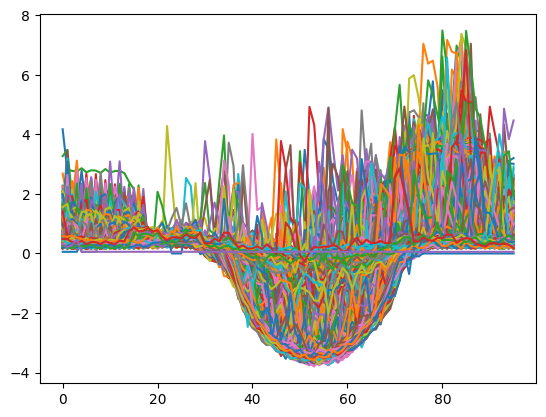

In [11]:
plt.close()
for i in range(365):
      plt.plot(tensor_grid[18][i])


In [12]:
print(tensor_grid.shape)

torch.Size([30, 365, 96])


In [13]:
torch.save(tensor_grid, "../data/Pecan Street Smart Meter Data (large) (tensor)/loads_raw.pt")